# Building Production Query Classifiers for RAG Systems

> **Series Overview**: This is the final notebook in our three-part series on systematically analyzing and improving RAG systems. We've discovered patterns and improved clustering—now we'll build production-ready classifiers to act on these insights.

> **Prerequisites**: Complete both "1. Cluster Conversations" and "2. Better Summaries" notebooks first. You'll need `instructor` and `instructor_classify` libraries installed, plus the labeled dataset from our clustering analysis.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/567-labs/kura/blob/main/docs/notebooks/how-to-look-at-data/03_classifiers_task.ipynb)

In [ ]:
# # Install kura in Google Colab
# !pip install kura
# !pip install instructor
# !pip install instructor git+https://github.com/jxnl/instructor-classify.git


# # Make sure you've setup your `OPENAI_API_KEY``
# # os.environ['OPENAI_API_KEY'] = <your api key here>
# import os
# from google.colab import userdata
# os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


# Create data directory and download dataset
DATA_DIRECTORY = "./data"
CHECKPOINT_DIRECTORY = "./checkpoints"

!mkdir -p {DATA_DIRECTORY}
!curl -o {DATA_DIRECTORY}/conversations.json https://usekura.xyz/assets/conversations.json
!curl -o {DATA_DIRECTORY}/labels.jsonl https://usekura.xyz/assets/labels.jsonl

## Why This Matters

**Discovery without action is just interesting data.** In our previous notebooks, we systematically analyzed 560 user queries and uncovered clear patterns through improved clustering. We know that three major themes—experiment management, artifact handling, and deployment—account for the majority of user questions. But knowing patterns exist in historical data isn't enough.

**To transform insights into improvements, we need real-time classification.** Specifically, we need to:

1. **Detect Production Drift** - Identify when certain query types suddenly increase, signaling emerging issues
2. **Route Queries Intelligently** - Direct questions to specialized retrieval pipelines based on their category
3. **Prioritize Improvements** - Focus engineering resources on high-volume, low-satisfaction query types
4. **Measure Impact** - Track how changes affect different user segments over time

**Classification bridges the gap between discovery and action**, transforming our topic modeling insights into a production-ready system for continuous RAG improvement.

## What You'll Learn

In this final notebook, you'll discover how to:

1. **Create Production-Ready Classifiers**
   - Build efficient classifiers using the `instructor-classify` framework
   - Generate weak labels automatically for rapid dataset creation
   - Design systematic workflows for human label verification

2. **Achieve High Classification Accuracy**
   - Start with baseline performance and iterate systematically
   - Apply advanced prompting techniques (system prompts, few-shot examples)
   - Measure and visualize improvements using confusion matrices

3. **Scale Classification to Full Datasets**
   - Apply optimized classifiers to thousands of queries efficiently
   - Understand true query distributions across your user base
   - Identify high-impact areas for targeted RAG improvements

## What You'll Achieve

**By the end of this notebook, you'll have built a classifier that achieves 90.9% accuracy**—improving from a 72.7% baseline through systematic prompt engineering. You'll discover that just three categories (artifacts, integrations, visualizations) account for 50% of all user conversations, giving you clear targets for maximum impact improvements.

**More importantly, you'll have a complete methodology for continuous RAG improvement**: discover patterns through clustering → validate with better summaries → monitor continuously through classification → prioritize improvements based on real usage data.

## From Reactive to Proactive RAG Systems

**Most RAG systems improve reactively**—waiting for user complaints or noticing obvious failures. **This series shows you how to build proactively improving systems** that identify problems before users complain and prioritize fixes based on systematic analysis rather than the loudest feedback.

By the end of this notebook, you'll have moved from "we think users struggle with X" to "we know 20% of users need help with artifacts, 15% with integrations, and 14% with visualizations—and we can automatically detect and route these queries for specialized handling."

## What You'll Learn

In this notebook, you'll discover how to:

1. **Generate Weak Labels and Create a Golden Dataset**
   - Create an initial classifier using the instructor-classify framework
   - Generate preliminary labels for your conversation dataset
   - Use app.py to review and correct weak labels for a high-quality labeled dataset

2. **Iteratively Improve Classification Accuracy**
   - Start with a simple baseline classifier
   - Enhance performance with few-shot examples and system prompts
   - Measure improvements using confusion matrices and accuracy metrics

3. **Analyze Query Distribution in Your Dataset**
   - Apply your optimized classifier to the full dataset
   - Understand the prevalence of different query types
   - Identify high-impact areas for RAG system improvements

Rather than trying to replicate all the nuanced clusters from our topic modeling, we'll focus on three high-impact categories that emerged from our analysis:

1. Artifacts - Questions about creating, versioning, and managing W&B artifacts
2. Integrations - Questions about integrating W&B with specific libraries and frameworks
3. Visualisations - Questions about creating charts, dashboards, and visual analysis
4. Other - General queries that don't fit the specialized categories above

By the end of this notebook, you'll have moved from "we discovered these patterns exist" to "we can automatically detect and act on these patterns in production."

## Defining Our Classifier

Our topic modeling revealed several distinct clusters of user queries, with three major topics accounting for the majority of questions:

1. Users seeking help with experiment tracking and metrics logging
2. Users trying to manage artifacts and data versioning
3. Users needing assistance with integrations and deployment

In this notebook, we'll show how we might build a classifier which can identify queries related to creating, managing and versioning weights and biases artifacts, questions about integrations as well as visualisations of data that's been logged.

1. First we'll define a simple classifier using `instructor-classify` that will take in a query and document pair and output a suggested category for it 
2. Then we'll see a few examples of the `instructor-classify` library in action
3. Lastly, we'll then generate a set of initial weak labels using this simple classifier before exporting it to a file for manual annotation using our `app.py` file.

Let's get started with the `instructor-classify` library

In [41]:
from instructor_classify.schema import LabelDefinition, ClassificationDefinition

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which is about creating, versioning and managing weights and biases artifacts.",
)

integrations_label = LabelDefinition(
    label="integrations",
    description="this is a user query and document pair which is concerned with how we can integrate weights and biases with specific libraries",
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query and document pair which is concerned about how we can visualise the data that we've logged with weights and biases",
)

other_label = LabelDefinition(
    label="other",
    description="Use this label for other query types which don't belong to any of the other defined categories that you have been provided with",
)


classification_def = ClassificationDefinition(
    system_message="You're an expert at classifying a user and document pair. Look closely at the user query and determine what the query is about and how the document helps answer it. Then classify it according to the label(s) above. Classify irrelevant ones as Other",
    label_definitions=[
        artifact_label,
        other_label,
        visualisation_label,
        integrations_label,
    ],
)

This structure makes it easy to define multiple categories in a way that's clear to both humans and LLMs. It provides explicit definitions of what each category means, making it easier for the model to make accurate predictions.

We also support exporing this configuration to a `.yaml` format for easy use if you're working with domain experts for easy collaboration.

### A Simple Example

Let's now see how `instructor-classify` works under the hood. We'll do so by passing in 4 sample queries and seeing how our classifier is able to deal with these test cases

In [137]:
import instructor
from instructor_classify.classify import Classifier
from openai import OpenAI

client = instructor.from_openai(OpenAI())
classifier = (
    Classifier(classification_def).with_client(client).with_model("gpt-4.1-mini")
)

# Make a prediction
result = classifier.predict("How do I version a weights and biases artifact?")
print(f"Classification: {result}")  # Should output "artifact";

result_2 = classifier.predict("What is the square root of 9?")
print(f"Classification: {result_2}")  # Should output "not_artifact"

Classification: label='artifact'
Classification: label='other'


`instructor-classify` exposes a `batch_predict` function which parallelises this operation for us so that we can run evaluations efficiently over large datasets. Let's see it in action below with some test cases


In [139]:
tests = [
    "How do I version a weights and biases artifact?",
    "What is the square root of 9?",
    "How do I integrate weights and biases with pytorch?",
    "What are some best practices when using wandb?",
    "How can I visualise my training runs?",
]

labels = ["artifact", "other", "integrations", "other", "visualisation"]

results = classifier.batch_predict(tests)
for query, result, label in zip(tests, results, labels):
    print(f"Query: {query}\nClassification: {result}\nExpected: {label}\n")

classify:   0%|          | 0/5 [00:00<?, ?it/s]

Query: How do I version a weights and biases artifact?
Classification: label='artifact'
Expected: artifact

Query: What is the square root of 9?
Classification: label='other'
Expected: other

Query: How do I integrate weights and biases with pytorch?
Classification: label='integrations'
Expected: integrations

Query: What are some best practices when using wandb?
Classification: label='other'
Expected: other

Query: How can I visualise my training runs?
Classification: label='visualisation'
Expected: visualisation



integrations_label = LabelDefinition(
    label="integrations",
    description="Query and document pairs about integrating Weights & Biases with specific libraries, frameworks, or platforms like PyTorch, OpenAI, YOLOv5, LangChain, and Hugging Face Accelerate.",
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="Query and document pairs about creating custom charts, confusion matrices, data visualization, tables, and exporting data from Weights & Biases.",
)

other_label = LabelDefinition(
    label="other",
    description="Query and document pairs covering general W&B features, best practices, experiment tracking, artifacts, sweeps, team collaboration, and other topics not specifically about integrations or visualization.",
)

In [11]:
import json

with open("./data/conversations.json") as f:
    conversations_raw = json.load(f)

texts = [
    {
        "query": item["query"],
        "matching_document": item["matching_document"],
        "query_id": item["query_id"],
    }
    for item in conversations_raw
]

results = classifier.batch_predict(texts[:110])

In [13]:
with open("./data/generated.jsonl", "w+") as f:
    for item, result in zip(conversations_raw, results):
        f.write(
            json.dumps(
                {
                    "query": item["query"],
                    "matching_document": item["matching_document"],
                    "query_id": item["query_id"],
                    "labels": result.label,
                }
            )
            + "\n"
        )

## Evaluating Our Classifier

We've manually labelled a dataset of approxiamtely 100 items with their respective labels ahead of time. If you'd like to label more items, we've provided an `app.py` file which you can download using the command below

```
!curl -o ./app.py https://usekura.xyz/assets/app.py
```

We'll be splitting this into a test and validation split. We'll be using the `validation` split to iterate on our prompt and experiment with different few shot examples before using the `test` split to validate our classifier's performance. 

We'll be using a 70-30 split with 70% of our data used for validation and 30% used for testing our final classifier. 

In [3]:
import json
import random

with open("./data/labels.jsonl") as f:
    conversations_labels = [json.loads(line) for line in f]

# Set random seed for reproducibility
random.seed(42)

# Shuffle the data
random.shuffle(conversations_labels)

# Calculate split index
split_idx = int(len(conversations_labels) * 0.7)

# Split into validation and test sets
val_set = conversations_labels[:split_idx]
test_set = conversations_labels[split_idx:]

print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Validation set size: 77
Test set size: 33


### Determining a baseline

Let's now calculate a baseline and see how well our initial classification model performs.

In [4]:
val_text = [
    f"<query>: {item['query']}</query>\n <corpus>{item['matching_document']}</corpus>"
    for item in val_set
]
val_labels = [item["label"] for item in val_set]

test_text = [
    f"<query>{item['query']}</query>\n <corpus>{item['matching_document']}</corpus>"
    for item in test_set
]
test_labels = [item["label"] for item in test_set]

Let's now define a function which runs the classifier on the validation set and the test set to see our initial starting point. We'll look at some of the failure cases and then iterately improve our classifier.

In [ ]:
from sklearn.metrics import confusion_matrix
from instructor_classify.classify import Classifier
import instructor


def predict_and_evaluate(classifier: Classifier, texts: list[str], labels: list[str]):
    predictions = classifier.batch_predict(texts)
    pred_labels = [p.label for p in predictions]

    return {
        "accuracy": sum(pred == label for pred, label in zip(pred_labels, labels))
        / len(predictions),
        "queries": texts,
        "labels": labels,
        "predictions": pred_labels,
    }


model_name = "gpt-4o-mini-2024-07-18"
client = instructor.from_provider("openai/gpt-4o-mini-2024-07-18")
classifier = Classifier(classification_def).with_client(client).with_model(model_name)
predictions = predict_and_evaluate(classifier, val_text, val_labels)
predictions["accuracy"]

0.5454545454545454

<Figure size 1000x800 with 0 Axes>

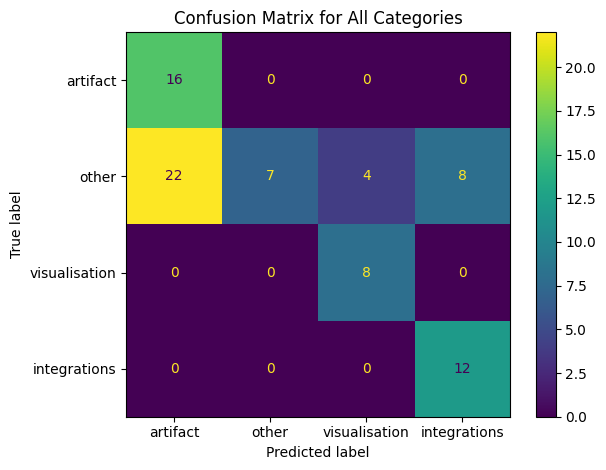

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [unique_labels.index(label) for label in predictions["labels"]]
y_pred = [unique_labels.index(label) for label in predictions["predictions"]]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

Let's now see how it looks like when we run it on our test set

In [9]:
test_predictions = predict_and_evaluate(classifier, test_text, test_labels)
test_predictions["accuracy"]

0.6060606060606061

<Figure size 1000x800 with 0 Axes>

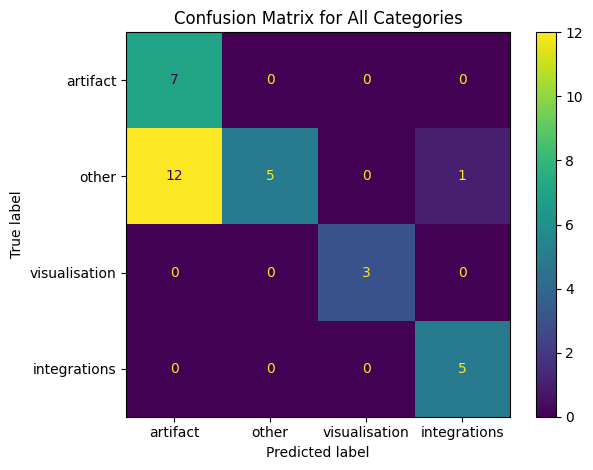

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [unique_labels.index(label) for label in test_predictions["labels"]]
y_pred = [unique_labels.index(label) for label in test_predictions["predictions"]]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

### Looking at Edge Cases

Let's now print out some of the errors that our model made in classifying our user queries

In [12]:
for prediction, label, query in zip(
    test_predictions["predictions"],
    test_predictions["labels"],
    test_predictions["queries"],
):
    if label != prediction:
        print(f"Label: {label}")
        print(f"Prediction: {prediction}")
        print(f"Query:\n{query}")
        print("=====")

Label: other
Prediction: artifact
Query:
<query>Version control of datasets in machine learning projects</query>
 <corpus>## Version Control in Machine Learning
### Data Version Control
* Data preprocessing (data content changes) such as data cleaning, outlier handling, filling of missing values, etc.
* Feature engineering (data becomes "wider") such as aggregation features, label encoding, scaling, etc.
* Dataset splits (data is partitioned) typically mean dividing your data into training, validation, and testing data.
* Dataset update (data becomes "longer") when new data points are available.</corpus>
=====
Label: other
Prediction: artifact
Query:
<query>can you provide a bit more clarity on the difference between setting `resume` in `wandb.init` to `allow` vs. `auto`?

I guess the difference has to do with whether the previous run crashed or not. I guess if the run didn't crash, `auto` may overwrite if there's matching `id`?</query>
 <corpus>| `resume` | (bool, str, optional) Sets 

When exmaining our confusion matrices in detail, we observe a consistent pattern of misclassification in the "other" category where our classifier frequently misidentifies these queries by assigning them to one of our specific categories.

Looking at the classification errors, we can identify several patterns

1. `Context Confusion` : The model tends to ignore the user's specific question but instead gets confused by the retrieved document. If a document contains specific bits of information about an artifact, even if the user's question is simply a general question.
2. `Over-Eagerness` : The model tends to prefer assigning specialised categories rathern than the more general "other" category, even when evidence is limited. This results in false positives for our specialised categories.

To address these issues, we'll need to carefully craft our prompts to help the model better distinguish between general W&B functionality and specific feature categories. 

By combining improved system prompts with strategically selected few-shot examples, we can guide the model to pay closer attention to the user's actual intent rather than being misled by terminology in the retrieved documents. 

Our next steps will focus on implementing these improvements and measuring their impact on classification accuracy, particularly for the challenging "other" category where most of our errors occur.

## Improving Our Classifier

Our baseline classifier achieved approximately 73% accuracy on the validation set, but the confusion matrices revealed significant challenges with the "other" category. 

To address these issues, we'll take a systematic approach to enhancement:

1. Refining system prompts to provide clearer boundaries between categories and explicitly instruct the model on how to handle ambiguous cases
2. Adding few-shot examples that demonstrate the correct handling of edge cases, particularly for general queries that mention specialized terms

Let's get started and see how to do so.

### System Prompt

The first improvement we'll implement is a more precise system prompt. Our error analysis showed that the model frequently misclassifies general queries as specialized categories when the retrieved document mentions features like artifacts or visualisations.

By providing explicit instructions about how to prioritize the user's query over the retrieved document and establishing clearer category boundaries, we can help the model make more accurate distinctions. We'll also provide a clear description of what each category represents so taht the model can make more accurate distinctions.

In [83]:
import instructor
from instructor_classify.classify import Classifier
from instructor_classify.schema import LabelDefinition, ClassificationDefinition
from openai import OpenAI

client = instructor.from_openai(OpenAI())

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query about how to manage, version and track artifacts with weights and biases",
)

integrations_label = LabelDefinition(
    label="integrations",
    description="This is a user query about how to use weights and biases with specific software libraries or platforms",
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query about how to use weights and biases to visualise and track the data that they have collected collected",
)

other_label = LabelDefinition(
    label="other",
    description="This should be used as a general label for any query that does not exactly fit into any of the other three categories above",
)

SYSTEM_PROMPT = """
You're going to be provided with a query and corpus. Look closely and understand what the query is about and how the document is relevant to the query. Make sure to only consider the parts that are relevant to answering the user's specific question.

Here are the different categories that you should consider. If you're unsure of a category, choose other.

1. Integrations : This should be for queries about connecting W&B with external libraries/frameworks
2. Visualisations : This should be for queries about creating custom charts, data visualisation tools, plotting using W&B
3. Artifact : This should be for queries that deal with W&B artifact's system for dataset/model versioning. This does not include general file saving, logging, general model/experiment tracking or storage of data
4. Others - This is a generic category for questions that aren't captured by the categories above. When in doubt, always default to "other" for general feature questions
"""
classification_def_w_system_prompt = ClassificationDefinition(
    system_message=SYSTEM_PROMPT,
    label_definitions=[
        artifact_label,
        other_label,
        visualisation_label,
        integrations_label,
    ],
)

In [84]:
client = instructor.from_openai(OpenAI())
classifier_v2 = (
    Classifier(classification_def_w_system_prompt)
    .with_client(client)
    .with_model(model_name)
)

In [85]:
predictions_system_prompt = predict_and_evaluate(classifier_v2, val_text, val_labels)
predictions_system_prompt["accuracy"]

0.7792207792207793

In [86]:
test_predictions_system_prompt = predict_and_evaluate(
    classifier_v2, test_text, test_labels
)
test_predictions_system_prompt["accuracy"]

0.8181818181818182

Let's now see how our model performs by using a confusion matrix

<Figure size 1000x800 with 0 Axes>

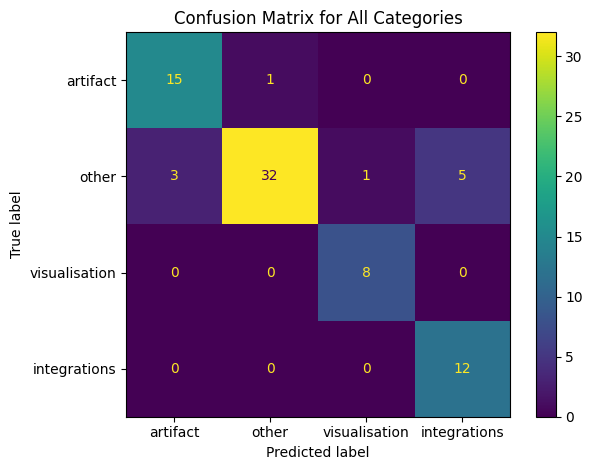

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [unique_labels.index(label) for label in predictions_system_prompt["labels"]]
y_pred = [
    unique_labels.index(label) for label in predictions_system_prompt["predictions"]
]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

It seems that with this new prompt, we've seen a roughly 16% improvement in our accuracy. One major issue seems to be classifying queries as the `other` category well. Let's visualise some of these queries

In [87]:
for prediction, label, query in zip(
    predictions_system_prompt["predictions"],
    predictions_system_prompt["labels"],
    predictions_system_prompt["queries"],
):
    if label != prediction:
        print(f"Label: {label}")
        print(f"Prediction: {prediction}")
        print(f"Query: {query}")
        print("=====")

Label: other
Prediction: integrations
Query: <query>: Bayesian optimization</query>
 <corpus>## Methods for Automated Hyperparameter Optimization
### Bayesian Optimization
Bayesian optimization is a hyperparameter tuning technique that uses a surrogate function to determine the next set of hyperparameters to evaluate. In contrast to grid search and random search, Bayesian optimization is an informed search method.  

### Inputs  

* A set of hyperparameters you want to optimize
* A continuous search space for each hyperparameter as a value range
* A performance metric to optimize
* Explicit number of runs: Because the search space is continuous, you must manually stop the search or define a maximum number of runs.  

The differences in grid search are highlighted in bold above.  

A popular way to implement Bayesian optimization in Python is to use BayesianOptimization from the [bayes_opt](https://github.com/fmfn/BayesianOptimization) library. Alternatively, as shown below, you can set

### Few Shot Examples

Building on our improved system prompt, we'll now add few-shot examples to our classifier. Few-shot examples provide concrete demonstrations of how to handle tricky edge cases, teaching the model through specific instances rather than abstract rules. This approach is particularly effective for resolving the context confusion and over-eagerness issues we identified in our error analysis.


For each label category, we've carefully selected examples that illustrate:
- Clear positive cases that should be assigned to that category
- Negative cases that might seem related but actually belong elsewhere

An example is when we show queries which were previously classified as integrations (Eg. using AWS IAM ) as others since these are authorization related.

In [199]:
import instructor
from instructor_classify.schema import (
    LabelDefinition,
    ClassificationDefinition,
    Examples,
)
from openai import OpenAI

client = instructor.from_openai(OpenAI())

aartifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query about how to manage, version and track artifacts with weights and biases",
    examples=Examples(
        examples_negative=["how do I use the model registry?"],
        examples_positive=[
            "how can I save versions of my code and models using artifacts across different runs?"
        ],
    ),
)

integrations_label = LabelDefinition(
    label="integrations",
    description="This is a user query about how to use weights and biases with specific software libraries or platforms",
    examples=Examples(
        examples_negative=[
            "how do I run a hyperparameter sweep with W&B"
        ],
        examples_positive=["How can I use w&B with langchain?"],
    ),
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query about how to use weights and biases to visualise and track the data that they have collected collected",
)

other_label = LabelDefinition(
    label="other",
    description="This should be used as a general label for any query that does not exactly fit into any of the other three categories above",
    examples=Examples(
        examples_positive=[
            "can I log images with weights and biases?",
            "what optimization methods does W&B support (e.g., Bayesian, grid search)?",
            "how do I run a hyperparameter sweep with W&B",
            "How to implement AWS IAM authentication",
            "distributed wandb usage"
        ],
    ),
)


classification_def_w_system_prompt_and_examples = ClassificationDefinition(
    system_message=SYSTEM_PROMPT,
    label_definitions=[
        artifact_label,
        other_label,
        visualisation_label,
        integrations_label,
    ],
)

classifier_v3 = (
    Classifier(classification_def_w_system_prompt_and_examples)
    .with_client(client)
    .with_model(model_name)
)

In [200]:
predictions_system_prompt_and_examples = predict_and_evaluate(
    classifier_v3, val_text, val_labels
)
predictions_system_prompt_and_examples["accuracy"]

0.8961038961038961

In [202]:
for prediction, label, query in zip(
    predictions_system_prompt_and_examples["predictions"],
    predictions_system_prompt_and_examples["labels"],
    predictions_system_prompt_and_examples["queries"],
):
    if label != prediction and prediction == "integrations":
        print(f"Label: {label}")
        print(f"Prediction: {prediction}")
        print("## Query")
        print(f"{query}")
        print("=====")

Label: other
Prediction: integrations
## Query
<query>: Weights & Biases features for LLM developers</query>
 <corpus>**Weights & Biases Prompts** is a suite of LLMOps tools built for the development of LLM-powered applications.  

Use W&B Prompts to visualize and inspect the execution flow of your LLMs, analyze the inputs and outputs of your LLMs, view the intermediate results and securely store and manage your prompts and LLM chain configurations.  

#### 🪄 View Prompts In Action  

**In this notebook we will demostrate W&B Prompts:**  

* Using our 1-line LangChain integration
* Using our Trace class when building your own LLM Pipelines  

See here for the full W&B Prompts documentation  

## Installation  

```
!pip install "wandb>=0.15.4" -qqq
!pip install "langchain>=0.0.218" openai -qqq

```  

```
import langchain
assert langchain.__version__ >= "0.0.218", "Please ensure you are using LangChain v0.0.188 or higher"

```  

## Setup  

This demo requires that you have an OpenAI k

<Figure size 1000x800 with 0 Axes>

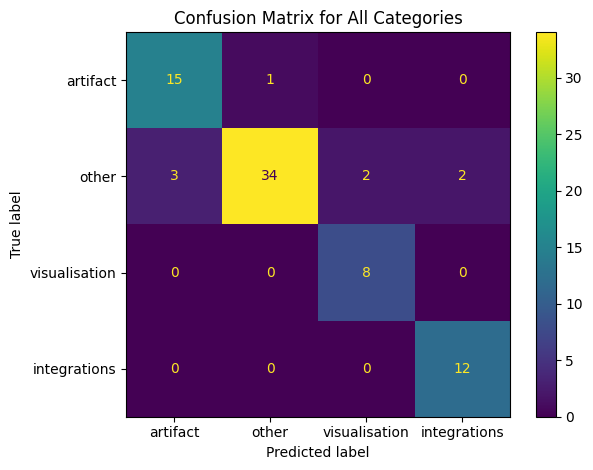

In [203]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [
    unique_labels.index(label)
    for label in predictions_system_prompt_and_examples["labels"]
]
y_pred = [
    unique_labels.index(label)
    for label in predictions_system_prompt_and_examples["predictions"]
]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

Let's now see the performance of this classifier on the test set

In [204]:
predictions_system_prompt_and_examples = predict_and_evaluate(
    classifier_v3, test_text, test_labels
)
predictions_system_prompt_and_examples["accuracy"]

0.8787878787878788

# Performance Evolution: From Baseline to Optimized Classifier

Let's examine how systematic changes to our prompting strategy transformed our classifier's performance:

| Prompt | Baseline | System Only | System + Examples |
|--------|----------|-------------|------------------|
| Accuracy | 54.5% | 77.9% (+43.1%) | 89.6% (+64.4%) |

These improvements demonstrate the power of thoughtful prompt engineering. By adding a clear system prompt, we saw a significant 43.1% relative improvement. When we further enhanced this with carefully selected examples, we achieved an additional 64.4% gain relative to our baseline, bringing our final validation accuracy to 89.6%. This trend was similarly observed with our holdout test set, where we maintained this high performance level - achieving a 87.8% accuracy compared to the baseline's 60.6%. 

This consistency between validation and test performance suggests our improvements are robust and generalizable.



## Application

Now that we've built and validated a classifier with over almost 90% accuracy, we can confidently apply it to our entire dataset to understand the true distribution of user queries. This isn't just an academic exercise - it's a powerful tool for product development

In [205]:
with open("./data/conversations.json") as f:
    conversations_full = json.load(f)

dataset_texts = [
    f"<query>{item['query']}</query>\n<corpus>{item['matching_document']}</corpus>"
    for item in conversations_full
]

In [206]:
dataset_labels = classifier_v3.batch_predict(dataset_texts)

In [207]:
from collections import Counter

Counter([item.label for item in dataset_labels])

Counter({'other': 292,
         'artifact': 112,
         'integrations': 94,
         'visualisation': 62})

## Conclusion

In this final notebook, you built a production-ready query classifier through systematic prompt engineering, completing our three-part methodology for RAG system improvement.

### Key Achievements

- **89.6% classification accuracy** with 64.4% relative improvement over baseline through systematic prompt engineering
- **Clear query distribution insights**: 20% artifacts, 17% integrations, 11% visualizations, 52% general queries across 560 conversations
- **Production-ready methodology**: From discovery (clustering) → validation (summaries) → monitoring (classification) → targeted improvements

### Production Impact

This classifier transforms reactive customer support into proactive system improvement. With nearly half of all queries (48%) falling into three specific categories, you can now focus engineering resources where they'll have maximum impact. Instead of guessing what users struggle with, you have concrete data showing that artifact workflows, framework integrations, and visualization tools are your highest-priority improvement areas.

### What's Next

You now have the foundation for advanced RAG capabilities: specialized retrieval pipelines for each category, intelligent query routing to domain experts, real-time monitoring of user needs, and data-driven prioritization of features and documentation. The key insight from this series is that RAG improvement isn't about better models alone—it's about systematically understanding your users and building focused solutions for their actual needs.

This approach transforms vague user feedback into actionable intelligence, enabling teams to measure improvement impact with precision and build more effective systems based on real usage patterns rather than assumptions.